# Building a Clinical Prediction Model

**=================================================================================================================**

## Project Description (My Answers are below if TLDR)

This assignment will be your opportunity to pull together all of the tools and techniques you have learned in this course and apply it to the real-world problem of building a clinical prediction model for identifying patients who are likely to die during their ICU stay. The goal of this assignment is not statistical accuracy of perfect modeling, but rather how you explain your methodological choices, evaluation and interpretation of results.

Citations:

Johnson A, Pollard T, Mark R. MIMIC-III Clinical Database Demo (version 1.4). PhysioNet. 2019. Available from: https://doi.org/10.13026/C2HM2Q.

**Project Data:** You can use any/all data available in the in mimic3_demo dataset. You should define the outcome variable as death during the ICU stay. 

**Algorithm Development Population:** Use ICU Admissions data for simplicity

**Algorithm Outcome:** Use the outcome of death during the ICU stay (hospital_expire_flag = 1)

**Algorithm Predictors:** You must use at least two clinical predictors - 'admission_type', 'insurance', 'marital_status', 'has_chartevents_data', drop all missing data

**Analytic Methodology and Validation:** Using basic Logistic Regression without balancing the target feature.

**Algorithm Implementation:** The model would need to be implemented in practice by combining some more data from different tables, collecting more new data for training the model to give better predictions.

## Data Tasks

### 1) Understand the shape of the data (Histograms, box plots, etc.)

### 2) Data Cleaning 

### 3) Data Exploration

### 4) Feature Engineering 

### 5) Data Preprocessing for Model

### 6) Basic Model Building 

### 7) Model Tuning 

### 8) Ensemble Model Building 

### 9) Results 

**=================================================================================================================**

## Import Libraries

In [1]:
import numpy as np
from numpy import count_nonzero, median, mean
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
#import squarify

import datetime
from datetime import datetime, timedelta, date

#import os
#import zipfile
import scipy
from scipy import stats
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.stats import boxcox
from collections import Counter

import sklearn
from sklearn.impute import KNNImputer, MissingIndicator, SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, Binarizer, OrdinalEncoder

from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config

set_config(transform_output="pandas")


from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.feature_selection import f_classif, chi2, RFE, RFECV
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.feature_selection import VarianceThreshold, GenericUnivariateSelect
from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile

from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.svm import SVC

import imblearn

from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTEN, SMOTENC 
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.metrics import classification_report_imbalanced
#from imblearn.pipeline import Pipeline

import feature_engine

from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures 
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
from feature_engine.selection import SelectBySingleFeaturePerformance



%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

plt.rc('axes', titlesize=9)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

# This module lets us save our models once we fit them.
# import pickle

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format','{:.2f}'.format)

random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


## Quick Data Glance

In [2]:
df = pd.read_csv("admissions.csv", parse_dates=['admittime', 'dischtime', 'deathtime'], dayfirst=1)

In [3]:
df.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   row_id                129 non-null    int64         
 1   subject_id            129 non-null    int64         
 2   hadm_id               129 non-null    int64         
 3   admittime             129 non-null    datetime64[ns]
 4   dischtime             129 non-null    datetime64[ns]
 5   deathtime             40 non-null     datetime64[ns]
 6   admission_type        129 non-null    object        
 7   admission_location    129 non-null    object        
 8   discharge_location    129 non-null    object        
 9   insurance             129 non-null    object        
 10  language              81 non-null     object        
 11  religion              128 non-null    object        
 12  marital_status        113 non-null    object        
 13  ethnicity           

In [5]:
df.dtypes.value_counts()

object            11
int64              5
datetime64[ns]     3
dtype: int64

In [6]:
# Descriptive Statistical Analysis
df.describe(include="all")

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
count,129.00,129.00,129.00,129,129,40,129,129,129,129,81,128,113,129,92,92,129,129.00,129.00
unique,NaN,NaN,NaN,129,129,40,3,5,10,4,5,10,6,9,92,92,95,NaN,NaN
top,NaN,NaN,NaN,2164-10-23 21:09:00,2164-11-01 17:15:00,2126-08-28 18:59:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,NaN,NaN
freq,NaN,NaN,NaN,1,1,1,119,81,40,98,58,59,60,86,1,1,10,NaN,NaN
first,NaN,NaN,NaN,2102-08-29 07:15:00,2102-09-06 16:20:00,2105-06-11 02:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2202-10-03 01:45:00,2202-10-11 16:30:00,2192-05-15 19:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,28036.44,28010.41,152343.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.31,0.99
std,14036.55,16048.50,27858.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.46,0.09
min,12258.00,10006.00,100375.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00
25%,12339.00,10088.00,128293.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00


In [7]:
# Descriptive Statistical Analysis
df.describe(include=["int", "float"])

,row_id,subject_id,hadm_id,hospital_expire_flag,has_chartevents_data
count,129.00,129.00,129.00,129.00,129.00
mean,28036.44,28010.41,152343.44,0.31,0.99
std,14036.55,16048.50,27858.79,0.46,0.09
min,12258.00,10006.00,100375.00,0.00,0.00
25%,12339.00,10088.00,128293.00,0.00,1.00
50%,39869.00,40310.00,157235.00,0.00,1.00
75%,40463.00,42135.00,174739.00,1.00,1.00
max,41092.00,44228.00,199395.00,1.00,1.00


In [8]:
# Descriptive Statistical Analysis
df.describe(include="object")

,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis
count,129,129,129,129,81,128,113,129,92,92,129
unique,3,5,10,4,5,10,6,9,92,92,95
top,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS
freq,119,81,40,98,58,59,60,86,1,1,10


In [9]:
df.shape

(129, 19)

In [10]:
df.columns

Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data'], dtype='object')

In [11]:
df.isnull().sum()

row_id                   0
subject_id               0
hadm_id                  0
admittime                0
dischtime                0
deathtime               89
admission_type           0
admission_location       0
discharge_location       0
insurance                0
language                48
religion                 1
marital_status          16
ethnicity                0
edregtime               37
edouttime               37
diagnosis                0
hospital_expire_flag     0
has_chartevents_data     0
dtype: int64

In [12]:
df.duplicated().sum()

0

In [13]:
df.drop(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'edregtime', 'edouttime'], axis=1, inplace=True)

In [14]:
df.head()

,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,diagnosis,hospital_expire_flag,has_chartevents_data
0,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,SEPSIS,0,1
1,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,HEPATITIS B,1,1
2,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,SEPSIS,1,1
3,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,HUMERAL FRACTURE,0,1
4,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,ALCOHOLIC HEPATITIS,1,1


## Data Visualization

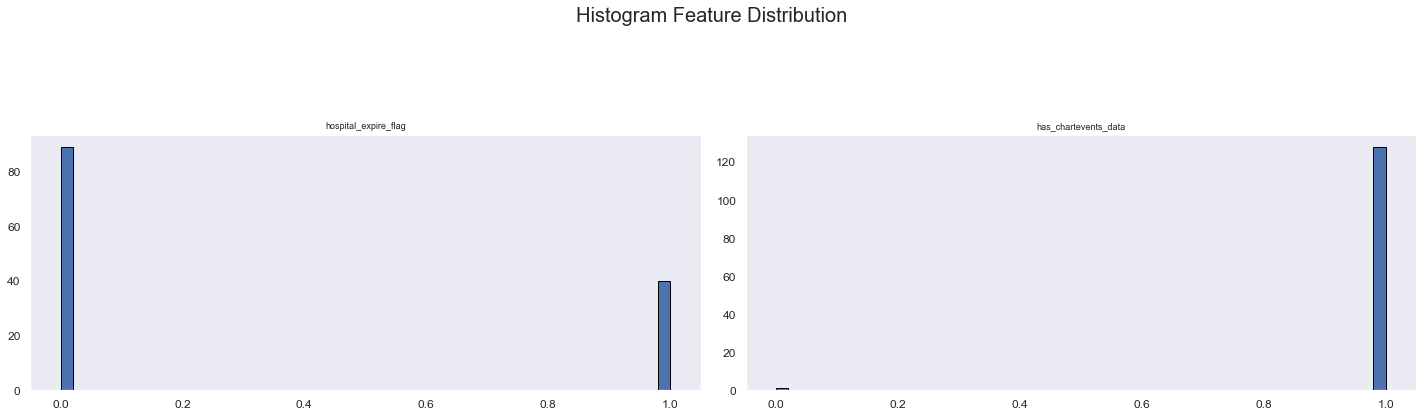

In [15]:
df.hist(bins=50, figsize=(20,45), grid=False, layout=(len(df.columns),2), edgecolor = 'black')
plt.suptitle('Histogram Feature Distribution', x=0.5, y=1.02, ha='center', fontsize=20)
plt.tight_layout()
plt.show()

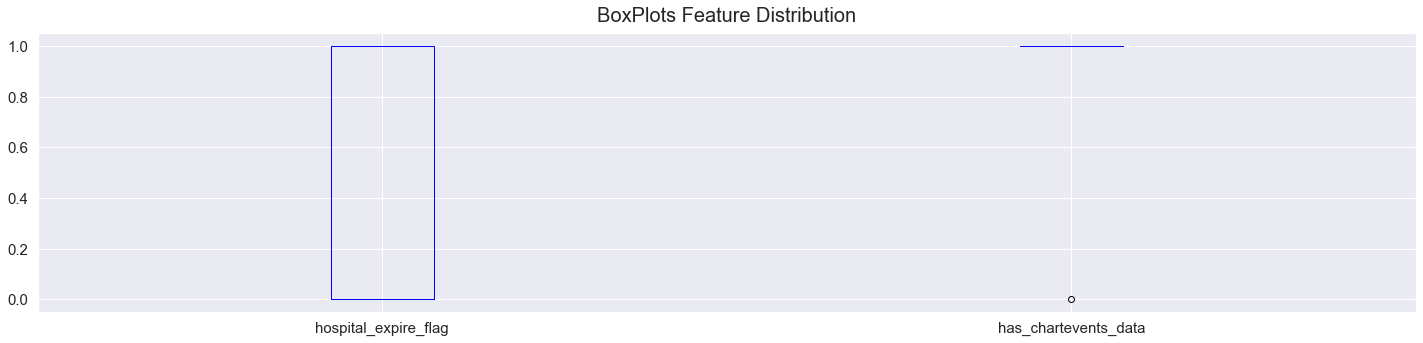

In [16]:
df.boxplot(figsize=(20,5), color="blue", fontsize = 15)
plt.title('BoxPlots Feature Distribution', x=0.5, y=1.02, ha='center', fontsize=20)
plt.tight_layout()
plt.show()

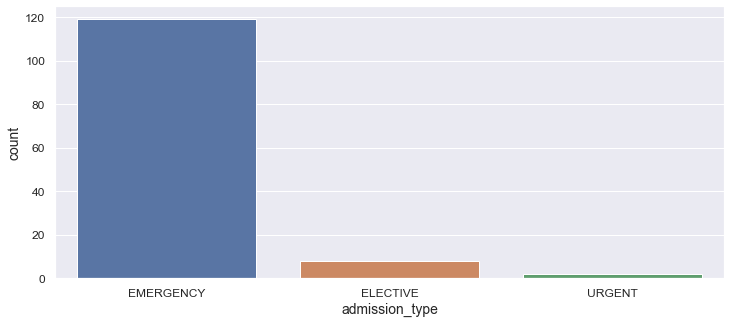

In [17]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=df.admission_type, data=df)
plt.show()

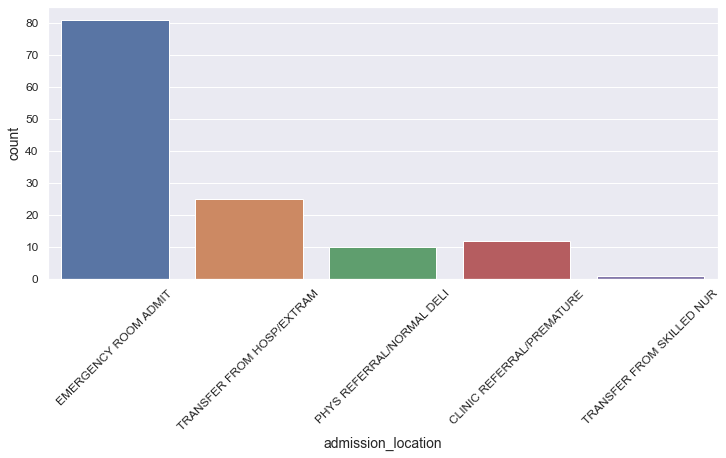

In [18]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=df.admission_location, data=df)
plt.xticks(rotation=45)
plt.show()

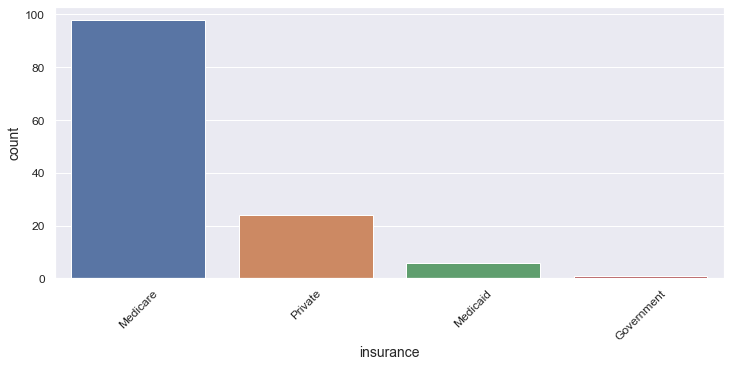

In [19]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=df.insurance, data=df)
plt.xticks(rotation=45)
plt.show()

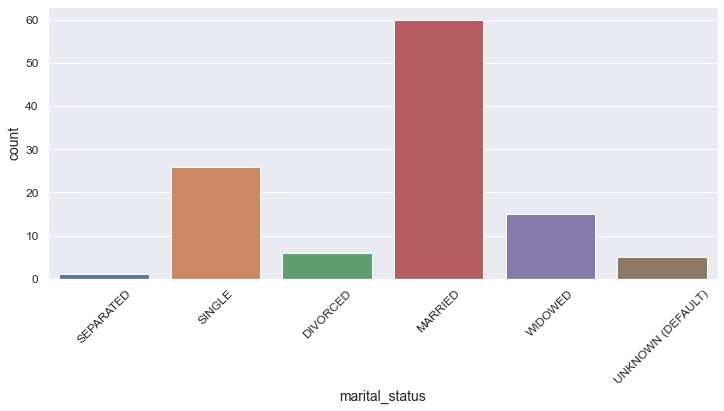

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=df.marital_status, data=df)
plt.xticks(rotation=45)
plt.show()

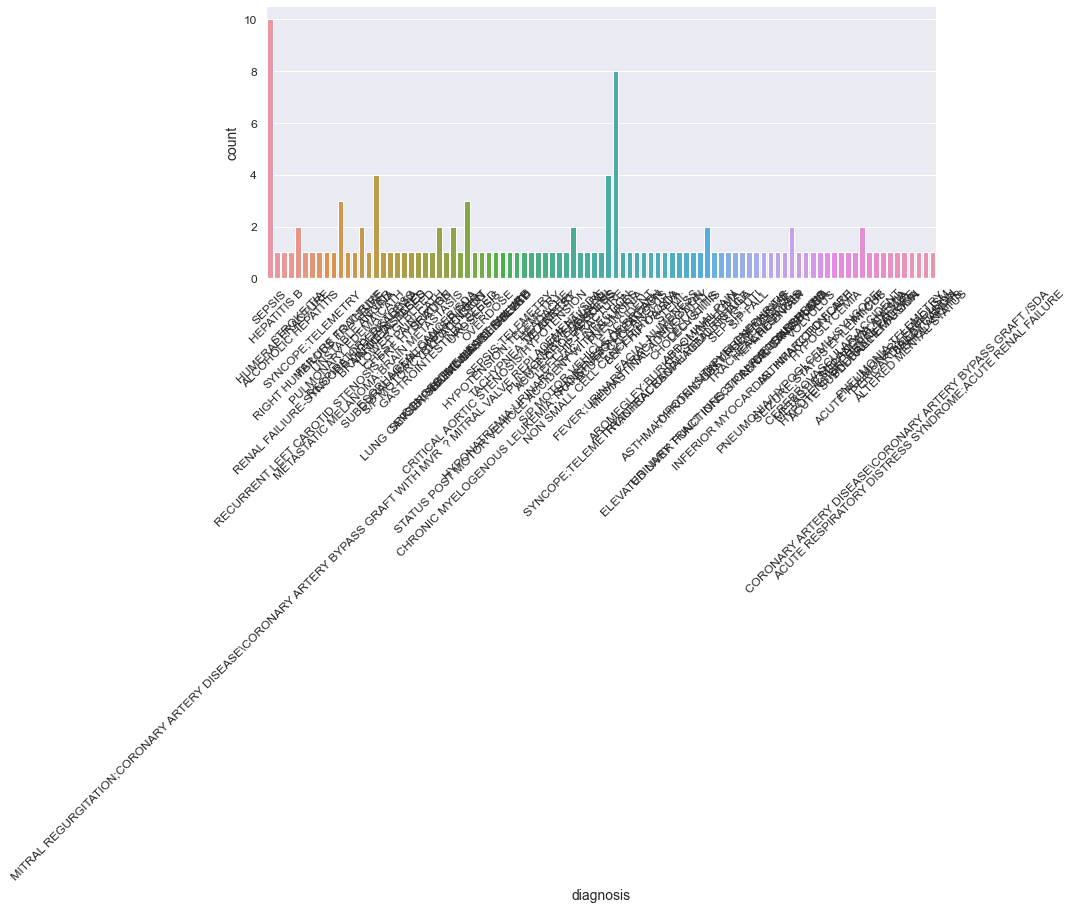

In [21]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=df.diagnosis, data=df)
plt.xticks(rotation=45)
plt.show()

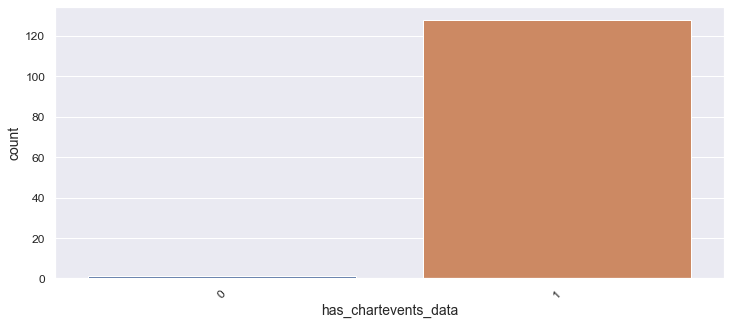

In [22]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=df.has_chartevents_data, data=df)
plt.xticks(rotation=45)
plt.show()

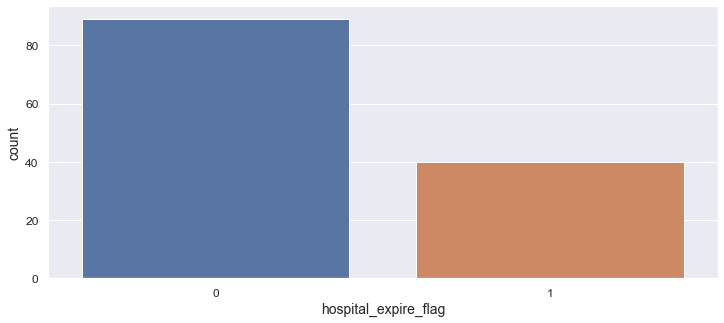

In [23]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x=df.hospital_expire_flag, data=df)
plt.show()

In [24]:
df.corr()

,hospital_expire_flag,has_chartevents_data
hospital_expire_flag,1.00,-0.13
has_chartevents_data,-0.13,1.00


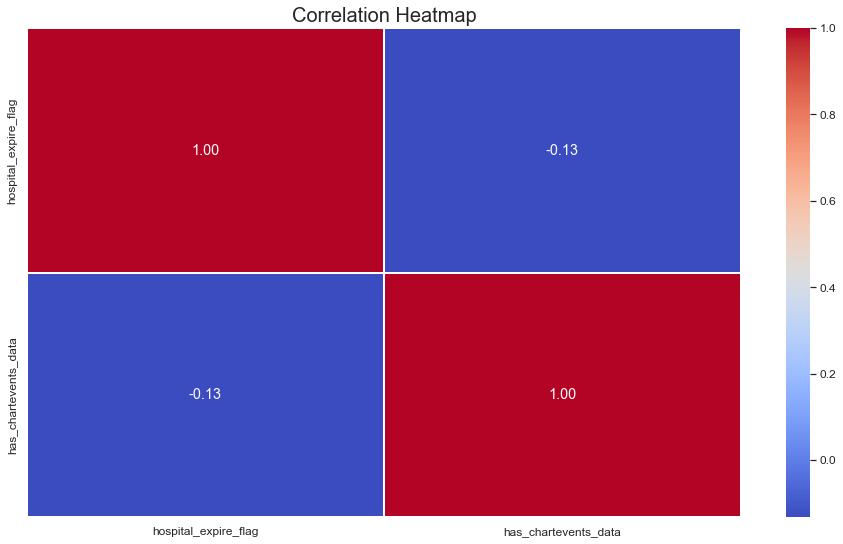

In [25]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.title("Correlation Heatmap", fontsize=20)
plt.show()

**==================================================================================================================**

## Train Test Split

We've prepared our data and we're ready to model. There's one last step before we can begin. We must split the data into features and target variable, and into training data and test data. We do this using the `train_test_split()` function. We'll put 25% of the data into our test set, and use the remaining 75% to train the model.

Notice below that we include the argument `stratify=y`. If our master data has a class split of 80/20, stratifying ensures that this proportion is maintained in both the training and test data. `=y` tells the function that it should use the class ratio found in the `y` variable (our target).

The less data you have overall, and the greater your class imbalance, the more important it is to stratify when you split the data. If we didn’t stratify, then the function would split the data randomly, and we could get an unlucky split that doesn’t get any of the minority class in the test data, which means we wouldn’t be able to effectively evaluate our model. Worst of all, we might not even realize what went wrong without doing some detective work.

Lastly, we set a random seed so we and others can reproduce our work.

<img src="trin-test.png">

In [26]:
df.shape

(129, 11)

In [27]:
df.columns

Index(['admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data'], dtype='object')

In [28]:
df.drop(['admission_location', 'discharge_location', 'language', 'religion', 'ethnicity', 'diagnosis'], axis=1, inplace=True)

In [29]:
df.columns

Index(['admission_type', 'insurance', 'marital_status', 'hospital_expire_flag', 'has_chartevents_data'], dtype='object')

In [30]:
df.isnull().sum()

admission_type           0
insurance                0
marital_status          16
hospital_expire_flag     0
has_chartevents_data     0
dtype: int64

In [31]:
df.dropna(inplace=True)

In [32]:
df.isnull().sum()

admission_type          0
insurance               0
marital_status          0
hospital_expire_flag    0
has_chartevents_data    0
dtype: int64

In [33]:
#df.to_csv("admissionscleaned.csv", index=False)

In [34]:
df = pd.read_csv("admissionscleaned.csv")

In [35]:
df.head()

,admission_type,insurance,marital_status,hospital_expire_flag,has_chartevents_data
0,EMERGENCY,Medicare,SEPARATED,0,1
1,EMERGENCY,Private,SINGLE,1,1
2,EMERGENCY,Medicare,DIVORCED,0,1
3,EMERGENCY,Medicare,DIVORCED,1,1
4,ELECTIVE,Medicare,MARRIED,0,1


In [36]:
X = df[['admission_type', 'insurance', 'marital_status', 'has_chartevents_data']]
y = df[['hospital_expire_flag']]

In [37]:
X.values, y.values

(array([['EMERGENCY', 'Medicare', 'SEPARATED', 1],
        ['EMERGENCY', 'Private', 'SINGLE', 1],
        ['EMERGENCY', 'Medicare', 'DIVORCED', 1],
        ['EMERGENCY', 'Medicare', 'DIVORCED', 1],
        ['ELECTIVE', 'Medicare', 'MARRIED', 1],
        ['EMERGENCY', 'Medicare', 'DIVORCED', 1],
        ['EMERGENCY', 'Medicare', 'WIDOWED', 1],
        ['EMERGENCY', 'Medicare', 'MARRIED', 1],
        ['ELECTIVE', 'Medicare', 'MARRIED', 1],
        ['EMERGENCY', 'Medicare', 'MARRIED', 1],
        ['EMERGENCY', 'Medicare', 'WIDOWED', 1],
        ['EMERGENCY', 'Medicare', 'UNKNOWN (DEFAULT)', 1],
        ['EMERGENCY', 'Medicare', 'MARRIED', 1],
        ['EMERGENCY', 'Medicaid', 'SINGLE', 1],
        ['EMERGENCY', 'Medicare', 'UNKNOWN (DEFAULT)', 1],
        ['EMERGENCY', 'Medicare', 'MARRIED', 1],
        ['EMERGENCY', 'Medicare', 'MARRIED', 1],
        ['EMERGENCY', 'Medicare', 'WIDOWED', 1],
        ['ELECTIVE', 'Private', 'SINGLE', 1],
        ['EMERGENCY', 'Medicare', 'MARRIED', 1],
   

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90, 4), (23, 4), (90, 1), (23, 1))

In [40]:
Counter(y_train), Counter(y_test)

(Counter({'hospital_expire_flag': 1}), Counter({'hospital_expire_flag': 1}))

In [41]:
y.value_counts()

hospital_expire_flag
0                       83
1                       30
dtype: int64

In [42]:
y.value_counts(normalize=True)

hospital_expire_flag
0                      0.73
1                      0.27
dtype: float64

**=================================================================================================================**

# Logistic Regression (Scikit Learn)

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size

Let's build our model using **LogisticRegression** from the Scikit-learn package. This function implements logistic regression and can use different numerical optimizers to find parameters, including ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’ solvers. You can find extensive information about the pros and cons of these optimizers if you search it in the internet.

The version of Logistic Regression in Scikit-learn, support regularization. Regularization is a technique used to solve the overfitting problem of machine learning models.
**C** parameter indicates **inverse of regularization strength** which must be a positive float. Smaller values specify stronger regularization.

## Logistic Model Evaluation

To determine which evaluation metric might be best, consider how our model might be wrong. There are two possibilities for bad predictions: 
  
  - **False positives:** When the model predicts a customer **will** churn when in fact they won't
  - **False negatives:** When the model predicts a customer will **not** churn when in fact they will     

As you know, there are a number of performance metrics aside from accuracy to choose from. Some of these include precision, recall, and F1 score. Let's examine these more closely, beginning with _precision_:

$$precision = \frac{\text{TP}}{\text{FP+TP}}$$
  </br> 

And _recall_: 

$$recall = \frac{\text{TP}}{\text{FN+TP}}$$  
  </br>
  


Precision represents the percentage of all our model's predicted positives that are true positives. This might not be the best metric for us to use, because it disincentivizes predicting someone will churn unless there is a high degree of certainty that they will. This could translate to a high rate of false negatives.

On the other hand, recall represents the percentage of all actual positives that the model identifies as such. This also might not be the best metric to use, because it rewards predicting someone will churn even if the likelihood of their doing so is very small. This could translate to a high rate of false positives.

So which is worse, false positives or false negatives? Well, we'd first have to define what _worse_ means. This is dependent on the details of the project that you're working on. For the sake of this exercise, let us suppose that we're defining it as the error that would cost the bank more money.

Since we don't know the exact cost of predicting a false negative, we'll make an assumption for this exercise. We'll assume that a metric that balances precision and recall is best. The metric that helps us achieve this balance is _F1 score_, which is defined as the harmonic mean of precision and recall. 

$${F_{1}} = 2 \cdot \frac{precision \cdot  recall}{precision + recall}$$  
</br>
Again, there are many metrics to choose from. The important thing is that you make an informed decision that is based on your use case.

**Question:** What are the four basic parameters for evaluating the performance of a classification model?

1. True positives (TP): These are correctly predicted positive values, which means the value of actual and predicted classes are positive. 

2. True negatives (TN): These are correctly predicted negative values, which means the value of the actual and predicted classes are negative.

3. False positives (FP): This occurs when the value of the actual class is negative and the value of the predicted class is positive.

4. False negatives (FN): This occurs when the value of the actual class is positive and the value of the predicted class in negative. 

**Reminder:** When fitting and tuning classification modeld, data professioals aim to minimize false positives and false negatives.

**Question:**  What do the four scores demonstrate about your model, and how do you calculate them?

- Accuracy (TP+TN/TP+FP+FN+TN): The ratio of correctly predicted observations to total observations. 
 
- Precision (TP/TP+FP): The ratio of correctly predicted positive observations to total predicted positive observations. 

- Recall (Sensitivity, TP/TP+FN): The ratio of correctly predicted positive observations to all observations in actual class.

- F1 score: The harmonic average of precision and recall, which takes into account both false positives and false negatives. 

**=================================================================================================================**

## Data Pipelines

Data Pipelines simplify the steps of processing the data. We use the module <code>Pipeline</code> to create a pipeline. 
`Pipeline` lets you chain together multiple operators on your data that both have a `fit` method.

### Combine multiple processing steps into a `Pipeline`

A pipeline contains a series of steps, where a step is ("name of step", actual_model). The "name of step" string is only used to help you identify which step you are on, and to allow you to specify parameters at that step.  

In [43]:
list(df.select_dtypes(include=["int64","float64"]))

['hospital_expire_flag', 'has_chartevents_data']

In [44]:
list(df.select_dtypes(include=["bool","object"]))

['admission_type', 'insurance', 'marital_status']

In [45]:
catcols = ['admission_type', 'insurance', 'marital_status']

In [46]:
# We create the preprocessing pipelines for both
# numerical and categorical data


# drop_transformer = ColumnTransformer(transformers=
#                                     ("dropcolumns", "drop", dropcols)
#                                     )

# numeric_transformer = Pipeline(steps=[
#                               #("imputer", SimpleImputer(missing_values=np.nan, strategy='mean')),
#                                ("scalar", StandardScaler()),
#                               #("minmax", MinMaxScaler()),
# ])

categorical_transformer = Pipeline(steps=[
    
                                  #("imputer", SimpleImputer(strategy="most_frequent")),
                                  #("onehot", OneHotEncoder(sparse_output=False, drop ='if_binary')),
    
                                  ("ordinal", OrdinalEncoder(categories='auto'))
    
    
])

In [47]:
preprocessor = ColumnTransformer(
               transformers=[
                           #("dropcolumns", "drop", []),
                           #("numerical", numeric_transformer, numcols),
                           ("categorical", categorical_transformer, catcols),
                   
                            ],
               remainder="passthrough",
               verbose_feature_names_out=False)

In [48]:
# Check features transformation (Train Set)

preprocessor.fit_transform(X_train)

,admission_type,insurance,marital_status,has_chartevents_data
6,1.00,2.00,5.00,1
3,1.00,2.00,0.00,1
99,0.00,3.00,1.00,1
56,1.00,3.00,1.00,1
35,1.00,3.00,3.00,1
...,...,...,...,...
22,1.00,2.00,4.00,1
8,0.00,2.00,1.00,1
90,1.00,2.00,3.00,1
27,1.00,0.00,1.00,1


In [49]:
# Check features transformation (Test Set)

preprocessor.transform(X_test)

,admission_type,insurance,marital_status,has_chartevents_data
20,1.00,2.00,1.00,1
63,1.00,2.00,1.00,1
37,1.00,2.00,1.00,1
88,1.00,2.00,3.00,1
77,1.00,2.00,1.00,1
57,1.00,2.00,3.00,1
59,1.00,2.00,5.00,1
66,1.00,2.00,1.00,1
17,1.00,2.00,5.00,1
53,1.00,2.00,5.00,1


In [50]:
train = preprocessor.fit_transform(X_train)
train.describe()

,admission_type,insurance,marital_status,has_chartevents_data
count,90.00,90.00,90.00,90.00
mean,0.94,2.12,2.06,0.99
std,0.31,0.52,1.52,0.11
min,0.00,0.00,0.00,0.00
25%,1.00,2.00,1.00,1.00
50%,1.00,2.00,1.00,1.00
75%,1.00,2.00,3.00,1.00
max,2.00,3.00,5.00,1.00


**=================================================================================================================**

## Logistic Regression Model (Baseline) - Only for Balanced Datasets

A baseline model is your first simple attempt at modelling which will provide you with a baseline metric that you will use as a reference point throughout development. This baseline model is often a heuristic (rule based) model, but could equally be a simple machine learning model.

In [51]:
logrpipeline = Pipeline(steps=
                     [
                      ("preprocessing", preprocessor),  
                      ( "logreg",  LogisticRegression(random_state=0))
                     ])

In [52]:
logrpipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['admission_type',
                                                   'insurance',
                                                   'marital_status'])],
                                   verbose_feature_names_out=False)),
                ('logreg', LogisticRegression(random_state=0))])

In [53]:
logr_pred = logrpipeline.predict(X_test)

In [54]:
logr_pred[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [55]:
logrpipeline.score(X_train,y_train)

0.7666666666666667

In [56]:
logrpipeline.score(X_test,y_test)

0.6956521739130435

In [57]:
prediction = pd.DataFrame(data=logr_pred, columns=['predicted'])
prediction

,predicted
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [58]:
y_test.reset_index(drop=True, inplace=True)
y_test

,hospital_expire_flag
0,1
1,0
2,0
3,0
4,0
5,0
6,1
7,0
8,0
9,0


In [59]:
tableslogr = pd.concat([y_test, prediction], axis=1)
tableslogr

,hospital_expire_flag,predicted
0,1,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,1,0
7,0,0
8,0,0
9,0,0


**==================================================================================================================**

## Logistic Regression Model Evaluation

In [60]:
print(classification_report(y_test,logr_pred))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82        17
           1       0.00      0.00      0.00         6

    accuracy                           0.70        23
   macro avg       0.36      0.47      0.41        23
weighted avg       0.54      0.70      0.61        23



In [61]:
cm = confusion_matrix(y_test,logr_pred)
cm

array([[16,  1],
       [ 6,  0]], dtype=int64)

In [62]:
# Show the classification report
print(classification_report_imbalanced(y_test, logr_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      0.94      0.00      0.82      0.00      0.00        17
          1       0.00      0.00      0.94      0.00      0.00      0.00         6

avg / total       0.54      0.70      0.25      0.61      0.00      0.00        23



In [63]:
print("Accuracy:", "%.3f" % accuracy_score(y_test, logr_pred))
print("Precision:", "%.3f" % precision_score(y_test, logr_pred))
print("Recall:", "%.3f" % recall_score(y_test, logr_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, logr_pred))
print("ROC-AUC Score:", "%.3f" % roc_auc_score(y_test, logr_pred))

Accuracy: 0.696
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
ROC-AUC Score: 0.471


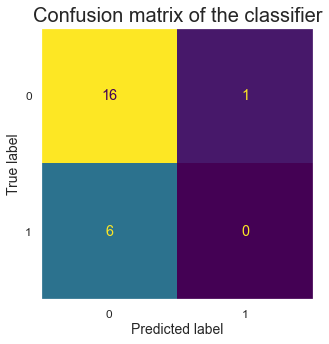

In [64]:
fig, ax = plt.subplots(figsize=(10,5))

ConfusionMatrixDisplay.from_estimator(estimator=logrpipeline, X=X_test, y=y_test, 
                                      ax=ax, display_labels=logrpipeline.classes_, colorbar=False)
ax.set_title('Confusion matrix of the classifier', size=20)
ax.grid(visible=False)
plt.show()

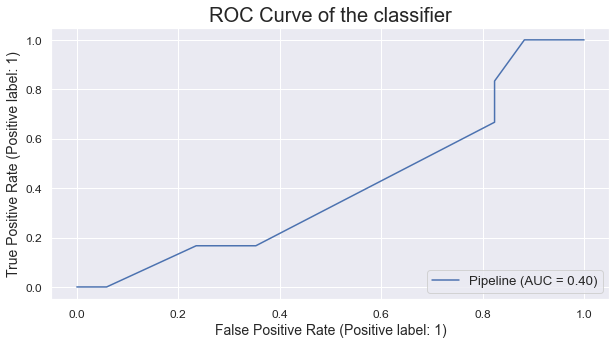

In [65]:
fig, ax = plt.subplots(figsize=(10,5))

RocCurveDisplay.from_estimator(estimator=logrpipeline, X=X_test, y=y_test, ax=ax)
ax.set_title('ROC Curve of the classifier', size=20)

plt.show()

In [66]:
lrtable = pd.DataFrame()
lrtable = lrtable.append({'Model': "Logistic Regression",
                        'F1':  f1_score(y_test, logr_pred),
                        'Recall': recall_score(y_test, logr_pred),
                        'Precision': precision_score(y_test, logr_pred),
                        'Accuracy': accuracy_score(y_test, logr_pred),
                        'ROC-AUC': roc_auc_score(y_test, logr_pred)
                      },
                        ignore_index=True)
                     
lrtable

,Model,F1,Recall,Precision,Accuracy,ROC-AUC
0,Logistic Regression,0.00,0.00,0.00,0.70,0.47


**==================================================================================================================**

#### Python code done by Dennis Lam